In [115]:
from matplotlib.pylab import rcParams
import xlrd
import os

ERROR! Session/line number was not unique in database. History logging moved to new session 417


In [116]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


In [117]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [118]:
rcParams["figure.figsize"] = 10,10

df = pd.read_excel(
     os.path.join("Case_License_Volume_2021-06-01_08-43-48.xlsx"),sheet_name="Data", engine='openpyxl',
)

# set dtypes
df["Period"] = pd.to_datetime(df.Period)

#dropna
df.dropna(how="any")

,Application Group,Case Complexity,Period,Application,Standard Case Equivalent,Case Count Country Factor,Case Count
0,ACESFW,BASIC,2021-05-01,ACESFW,6.4000,25.6000,32
1,ACESFW,BASIC,2021-04-01,ACESFW,8.1000,32.4000,38
2,ACESFW,BASIC,2021-03-01,ACESFW,9.0000,36.0000,39
3,ACESFW,BASIC,2021-02-01,ACESFW,16.4500,65.8000,76
4,ACESFW,BASIC,2021-01-01,ACESFW,2.6500,10.6000,12
...,...,...,...,...,...,...,...
1662,UOM,STANDARD,2021-05-01,E2ESI,297.4000,297.4000,299
1663,UOM,STANDARD,2021-04-01,E2EDI,1712.0000,1712.0000,1744
1664,UOM,STANDARD,2021-04-01,E2ESI,376.2000,376.2000,381
1665,UOM,STANDARD,2021-03-01,E2EDI,882.4000,882.4000,904


In [119]:
#we group the AG and Period as a sum to get the distinctive variables and avoid duplicates.
#here we create grouped Date Frame with out any index, in order to manipulate with AG and period later on.
df = df.groupby(["Application Group", "Period"], as_index = False).sum()

#to assign application groups to certain index we group them by App Gr.
df["Index"] = df.groupby(["Application Group"]).ngroup()

In [120]:
df

,Application Group,Period,Standard Case Equivalent,Case Count Country Factor,Case Count,Index
0,ACESFW,2020-05-01,0.4500,1.8000,3,0
1,ACESFW,2020-12-01,0.5000,2.0000,2,0
2,ACESFW,2021-01-01,2.6500,10.6000,12,0
3,ACESFW,2021-02-01,16.4500,65.8000,76,0
4,ACESFW,2021-03-01,9.0000,36.0000,39,0
...,...,...,...,...,...,...
386,UOM,2021-01-01,8117.8000,8117.8000,9392,24
387,UOM,2021-02-01,12116.6000,12116.6000,14057,24
388,UOM,2021-03-01,10478.4000,10478.4000,12133,24
389,UOM,2021-04-01,9800.8000,9800.8000,10929,24


In [121]:
#see the best fit application which corresponds max data points
lst = []
for i in range(0, 25):
    filt = df["Index"] == i
    model = df.loc[filt,["Period", "Case Count"]]
    m = [len(model)]
    lst = lst + m
print("Maximum of Datapoints:", max(lst),"\nApplication Name:", df.loc[filt,["Application Group"]].iloc[0,0], 
      "\nApplication Number:", i)
    


Maximum of Datapoints: 19 
Application Name: UOM 
Application Number: 24


In [122]:
new_df = df["Index"] == 24
df = df.loc[filt,["Period", "Case Count"]]
df

,Period,Case Count
372,2019-10-01,892
373,2019-11-01,981
374,2019-12-01,873
375,2020-01-01,993
376,2020-02-01,1737
377,2020-03-01,1851
378,2020-04-01,1986
379,2020-05-01,1961
380,2020-06-01,2012
381,2020-07-01,2072


In [123]:
df = df.set_index('Period').resample('MS').ffill() # fill the years if necessary
df

,Case Count
Period,
2019-10-01,892
2019-11-01,981
2019-12-01,873
2020-01-01,993
2020-02-01,1737
2020-03-01,1851
2020-04-01,1986
2020-05-01,1961
2020-06-01,2012


In [21]:
df

,Case Count
Period,
2019-10-01,892
2019-11-01,981
2019-12-01,873
2020-01-01,993
2020-02-01,1737
2020-03-01,1851
2020-04-01,1986
2020-05-01,1961
2020-06-01,2012


In [22]:
stat, p = stats.normaltest(df)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=4.080, p=0.130
Data looks Gaussian (fail to reject H0)


Kurtosis of normal distribution: [-0.65131341]
Skewness of normal distribution: [0.955243]


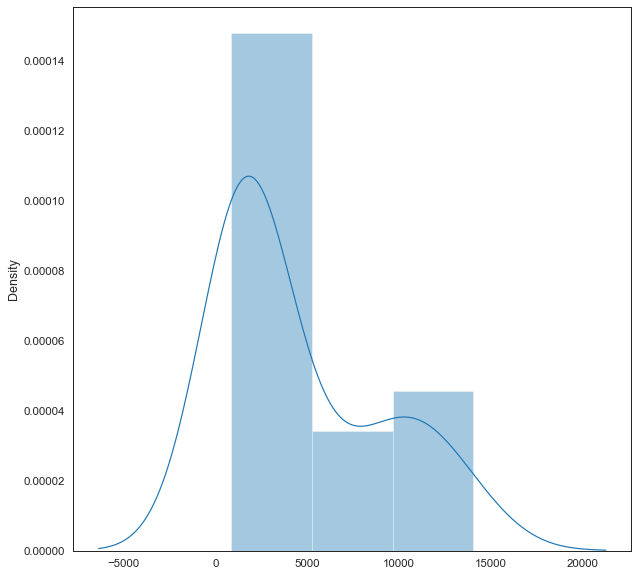

In [23]:
sns.distplot(df);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df)))

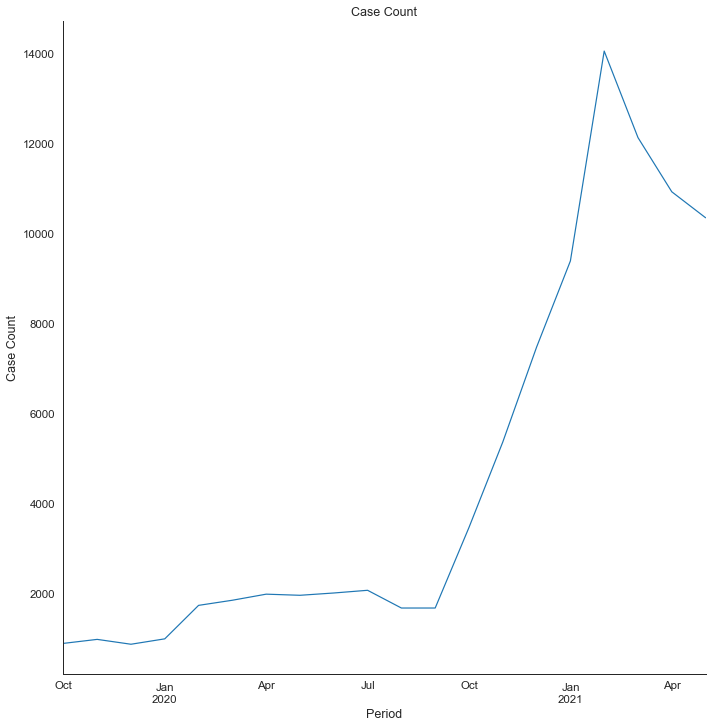

In [24]:
df.plot(figsize=(10,10))
plt.ylabel('Case Count')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Case Count')
sns.despine(top=True)
plt.show();

,count,mean,std,min,25%,50%,75%,max
Case Count,20.0000,4594.5500,4388.3497,873.0000,1678.0000,1999.0000,7955.7500,14057.0000


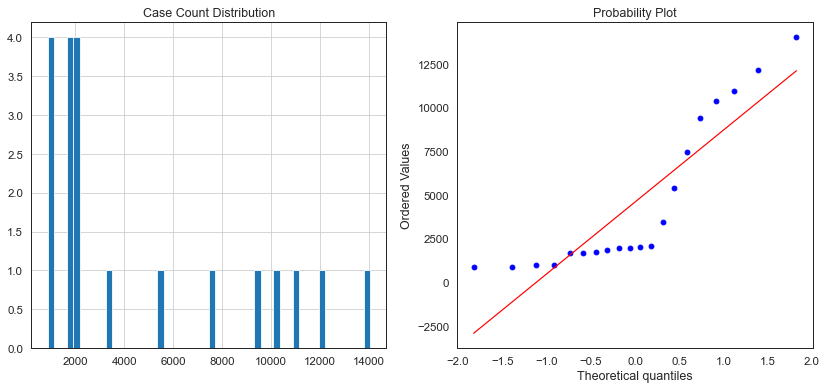

In [25]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Case Count'].hist(bins=50)
plt.title('Case Count Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Case Count'], plot=plt);
df.describe().T

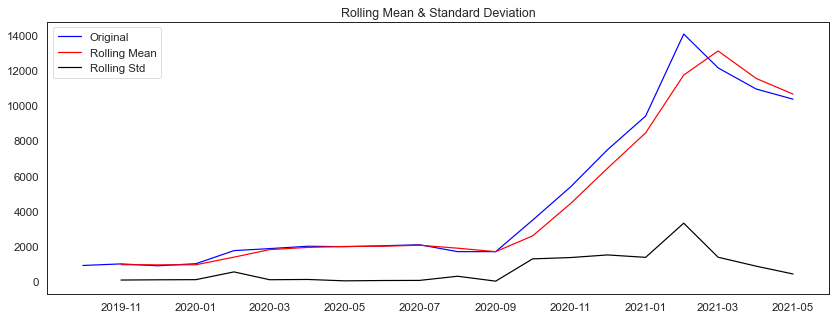

<Results of Dickey-Fuller Test>
Test Statistic                 1.7436
p-value                        0.9982
#Lags Used                     8.0000
Number of Observations Used   11.0000
Critical Value (1%)           -4.2232
Critical Value (5%)           -3.1894
Critical Value (10%)          -2.7298
dtype: float64


In [26]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=2).mean()
    rolstd = timeseries.rolling(window=2).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df)

In [ ]:

train_size = int(len(df) * 0.80)
# dataset = df["Case Count"] #numpy.ndarray

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = scaler.fit(df)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-114-4b9668228de3>", line 1, in <module>
    train_size = int(len(df) * 0.80)
TypeError: object of type 'StandardScaler' has no len()

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offs

## First way to prepare data

In [ ]:
# data normalization

train_size = int(len(df) * 0.80)
dataset = df["Case Count"] #numpy.ndarray

training_mean = dataset[:train_size].mean()
training_std = dataset[:train_size].std()

#standarize the data
y = (dataset-training_mean)/training_std


#define the function to prepare data.
#reorganize the data to form feature vectors and target values.

def data_process(dataset, iStart, iEnd, sHistory):
    data = []
    target = []
    if iEnd is None:
        iEnd = len(dataset)
    for i in range(iStart, iEnd):
        indices = range(i-sHistory,i)
        data.append(np.reshape(dataset[indices], (sHistory, 1)))
        target.append(dataset[i])
    return np.array(data), np.array(target)

# #lets define number of history data for training an dsplit data into training and testing datasets
past_history = 2
X_train, Y_train = data_process(y, 0, train_size, past_history)
X_test, Y_test = data_process(y, train_size, None, past_history)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-14a6c9fc5634>", line 36, in <module>
    X_train, Y_train = data_process(y, 0, train_size, past_history)
  File "<ipython-input-112-14a6c9fc5634>", line 30, in data_process
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 862, in _slice_helper
    _check_index(s)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 752, in _check_index
    raise TypeError(_SLICE_TYPE_ERROR + ", got {!r}".format(idx))
TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got range(-2, 0)

During handling of the above

In [98]:
X_test

array([[[1.94606392],
        [2.73885494]],

       [[2.73885494],
        [4.67011872]],

       [[4.67011872],
        [3.87360178]],

       [[3.87360178],
        [3.37515771]]])

In [91]:
import tensorflow as tf
#setting seed to ensure reproducibility
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer="Adam",
             loss ="mse")

In [102]:
BATCH_SIZE = 4
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
p_train = p_train.cache().shuffle(BATCH_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [104]:
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Train for 200 steps, validate for 50 stepsERROR! Session/line number was not unique in database. History logging moved to new session 
Epoch 1/10
409
200/200 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 16.1054
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 16.2013
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 16.3053
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 16.3945
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0231 - val_loss: 16.4772
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 16.5424
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 16.6217
Epoch 8/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 16.6813
Epoch 9/10
200/200 [==============================] -

<AxesSubplot:>

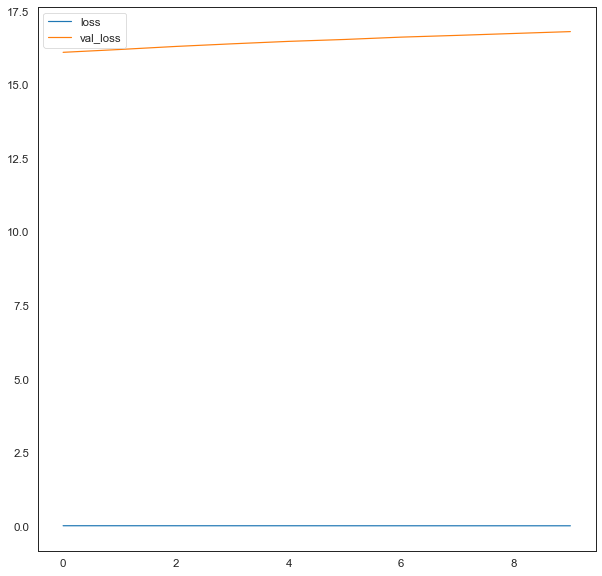

In [105]:
hist = pd.DataFrame(history.history)
hist.head()
hist.plot()

In [107]:
predicted_value = []
y_orig = []
count = 0;
for x, y in p_train.take(20):
    y_orig.append(y[0].numpy())
    t_pred = model.predict(x)
    predicted_value.append(t_pred[0])

In [110]:
#plot the values
y_pred = [predicted_value[i][0] for i in range (len(predicted_value))]
result = pd.DataFrame({"predicted":y_pred, "target": y_orig})


ERROR! Session/line number was not unique in database. History logging moved to new session 410


In [111]:
y_pred = 

train_predict = scaler.inverse_transform(train_predict)

Y_train = scaler.inverse_transform(Y_train.reshape(-1,1)).reshape(Y_train.shape)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)




[-0.7792001,
 -0.19112843,
 -0.3494185,
 -0.6369004,
 -0.5948723,
 -0.36493653,
 -0.6494796,
 -0.5000028,
 -0.6369004,
 -0.743872,
 -0.2983273,
 2.7359552,
 -0.5948723,
 -0.36493653,
 -0.3494185,
 2.7359552,
 -0.6369004,
 -0.13880047,
 -0.33852834,
 -0.14548215]

<AxesSubplot:>

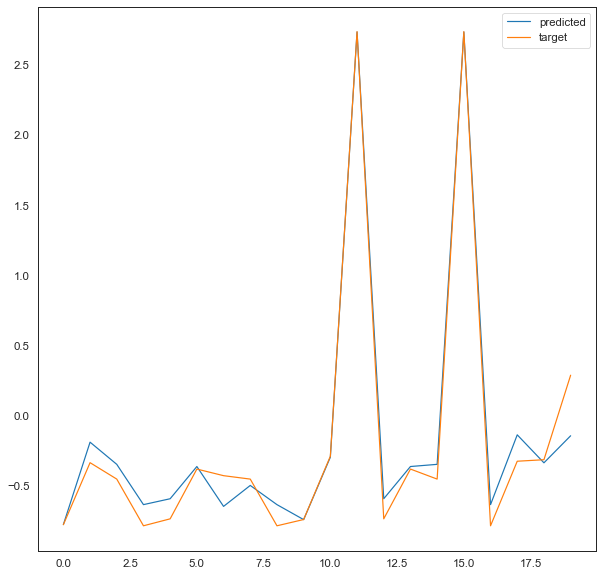

In [109]:
result.plot()

## Second Data Preparations

In [84]:
dataset = df["Case Count"].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), ]
        X.append(a)
        Y.append(dataset[i + look_back, ])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [85]:
len(X_test)


2

In [86]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=2000, batch_size=5, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 14 samples, validate on 2 samples
Epoch 1/2000
14/14 [==============================] - 0s 23ms/step - loss: 0.0315 - val_loss: 0.6542
Epoch 2/2000
14/14 [==============================] - 0s 497us/step - loss: 0.0292 - val_loss: 0.6254
Epoch 3/2000
14/14 [==============================] - 0s 573us/step - loss: 0.0271 - val_loss: 0.5980
Epoch 4/2000
14/14 [==============================] - 0s 567us/step - loss: 0.0251 - val_loss: 0.5717
Epoch 5/2000
14/14 [==============================] - 0s 570us/step - loss: 0.0230 - val_loss: 0.5464
Epoch 6/2000
14/14 [==============================] - 0s 499us/step - loss: 0.0215 - val_loss: 0.5224
Epoch 7/2000
14/14 [==============================] - 0s 499us/step - loss: 0.0201 - val_loss: 0.4998
Epoch 8/2000
14/14 [==============================] - 0s 427us/step - loss: 0.0199 - val_loss: 0.4784
Epoch 9/2000
14/14 [==============================] - 0s 570us/step - loss: 0.0185 - val_loss: 0.4582
Epoch 10/2000
14/14 [===================

In [688]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# # invert predictions
train_predict = scaler.inverse_transform(train_predict)

Y_train = scaler.inverse_transform(Y_train.reshape(-1,1)).reshape(Y_train.shape)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)



In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[:,:], train_predict[:,:]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[:,:], train_predict[:,:]))) #(predicted_values[:,-1,:],...)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[:,:], test_predict[:,:]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[0,0])))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Train Mean Absolute Error: 799.4225
Train Root Mean Squared Error: 930.4796
Test Mean Absolute Error: 1349.1294
Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-689-012fe31302e1>", line 4, in <module>
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[0,0])))
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\metrics\_regression.py", line 336, in mean_squared_error
    y_true, y_pred, multioutput)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\metrics\_regression.py", line 88, in _check_reg_targets
    check_consistent_length(y_true, y_pred)
  File "C:\Users\shurk\Anaconda3\envs\p

In [689]:
print (train_predict.shape) # (540, 4196)
print (Y_train.shape) # (136, 4196)
print (test_predict[:,0]) # (540,)
print (Y_test.shape)
print (Y_test[0])

(14, 1)
(14, 1)
[13854.3125 11905.946 ]
(2, 1)
[12133.]
ERROR! Session/line number was not unique in database. History logging moved to new session 379


## plot model loss

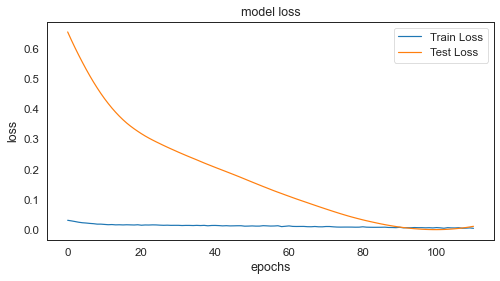

In [690]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [709]:
print(test_predict[:,0][:])
print(Y_test[:,0][:])

[13854.3125 11905.946 ]
[12133. 10929.]


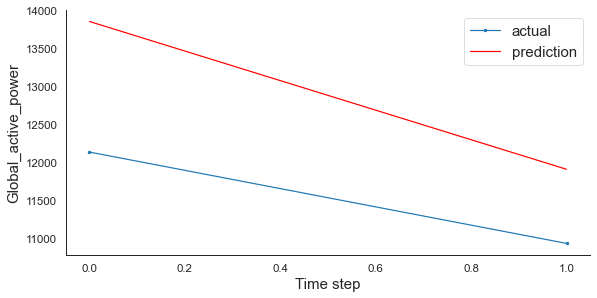

In [710]:
aa=[x for x in range(2)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:,0][:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [648]:
aa

[0]

ERROR! Session/line number was not unique in database. History logging moved to new session 369


In [ ]:
# invert predictions
train_predict = scaler.inverse_transform(p_train)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(p_test)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-21b86a0299d3>", line 2, in <module>
    train_predict = scaler.inverse_transform(p_train)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\preprocessing\_data.py", line 459, in inverse_transform
    force_all_finite="allow-nan")
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\sklearn\utils\validation.py", line 673, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "C:\Users\shurk\Anaconda3\envs\pytrch\lib\site-packages\numpy\core\_asarray.py", line 83, in asarray
    return array(a, dtype, copy=False, order=order)
TypeError: float() argument must be

## Easiest way to do it

In [290]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [291]:
# results = seasonal_decompose(df)
# results.plot();

In [582]:
len(df)

20

In [48]:
train = df.iloc[:18]
test = df.iloc[12:]
# train_size = int(len(dataset) * 0.80)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [49]:
len(test)

8

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [51]:
scaler.fit(train, test)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [52]:

scaled_test[:]

array([[0.19690534],
       [0.34094357],
       [0.50091019],
       [0.64616201],
       [1.        ],
       [0.85406553],
       [0.76274272],
       [0.71897755]])

In [53]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [60]:
# define generator
n_input = 8
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [61]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00144114 0.00819175 0.         0.00910194 0.06553398 0.07418083
 0.08442051 0.08252427]
Predict this y: 
 [[0.0863926]]


In [62]:
X.shape

(1, 8, 1)

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [64]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [66]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
10/10 [==============================] - 0s 36ms/step - loss: 0.2198
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.1710
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.1220
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.0831
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0655
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0633
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0579
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0498
Epoch 11/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0476
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.0401
Epoch 13/50
10/10 [=============================

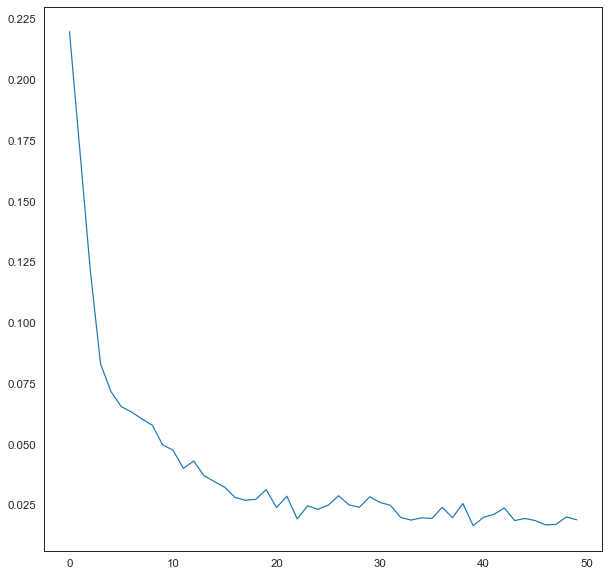

In [67]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [68]:
last_train_batch = scaled_train[-8:]

In [69]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [70]:
model.predict(last_train_batch)

array([[1.3506896]], dtype=float32)

In [71]:
scaled_test[0]

array([0.19690534])

In [72]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [73]:
test_predictions

[array([1.3506896], dtype=float32),
 array([1.9503222], dtype=float32),
 array([3.0202785], dtype=float32),
 array([4.942058], dtype=float32),
 array([9.095465], dtype=float32),
 array([19.518362], dtype=float32),
 array([47.32686], dtype=float32),
 array([116.68559], dtype=float32)]

In [74]:
test

,Case Count
Period,
2020-10-01,3469
2020-11-01,5368
2020-12-01,7477
2021-01-01,9392
2021-02-01,14057
2021-03-01,12133
2021-04-01,10929
2021-05-01,10352


In [76]:
true_predictions

array([[  18680.49234009],
       [  26586.04724121],
       [  40692.35113525],
       [  66029.09381104],
       [ 120787.60668945],
       [ 258203.08520508],
       [ 624830.30273438],
       [1539255.85351562]])

In [77]:
true_predictions = scaler.inverse_transform(test_predictions)

In [78]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Period'>

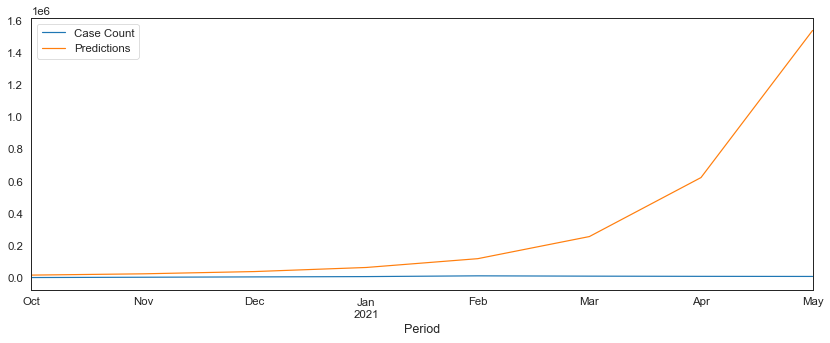

In [79]:
test.plot(figsize=(14,5))

In [647]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Case Count'],test['Predictions']))
print(rmse)

8779387.347953971


## 4th way to predict

In [289]:
train = df.iloc[:17].values
test = df.iloc[17:].values


[            Case Count
 Period                
 2021-03-01       12133
 2021-04-01       10929
 2021-05-01       10352]

,Case Count
Period,
2019-10-01,892
2019-11-01,981
2019-12-01,873
2020-01-01,993
2020-02-01,1737
2020-03-01,1851
2020-04-01,1986
2020-05-01,1961
2020-06-01,2012
